# Portland Trail Blazers - Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 8, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [4]:
lkupclientid = 36 # Calgary Flames

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrFlames].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(38523, 55)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38523 entries, 0 to 38522
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              38523 non-null  int64  
 1   dimCustomerMasterId       38523 non-null  int64  
 2   customerNumber            38523 non-null  object 
 3   year                      38523 non-null  object 
 4   productGrouping           38523 non-null  object 
 5   totalSpent                38523 non-null  float64
 6   recentDate                38523 non-null  object 
 7   attendancePercent         38523 non-null  float64
 8   renewedBeforeDays         38522 non-null  float64
 9   isBuyer                   38523 non-null  object 
 10  source_tenure             38523 non-null  int64  
 11  tenure                    38522 non-null  float64
 12  distToVenue               38523 non-null  float64
 13  totalGames                38523 non-null  int64  
 14  recenc

### Let's drop the features that have lots of null values, and any ID columns, as these won't be useful to our model:

In [19]:
df.drop([
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity', 
    'isnextyear_buyer', 
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.shape

(38523, 47)

### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [20]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(38523, 29)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [21]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38523 entries, 0 to 38522
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  38523 non-null  int64  
 1   renewedBeforeDays    38522 non-null  float64
 2   source_tenure        38523 non-null  int64  
 3   tenure               38522 non-null  float64
 4   totalGames           38523 non-null  int64  
 5   missed_games_1       38523 non-null  int64  
 6   missed_games_2       38523 non-null  int64  
 7   send_email           38523 non-null  int64  
 8   isNextYear_Buyer     38523 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 2.9 MB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [22]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,renewedBeforeDays,source_tenure,tenure,totalGames,missed_games_1,missed_games_2,send_email,isNextYear_Buyer
dimCustomerMasterId,1.00,0.11,0.10,0.12,0.11,0.06,0.02,-0.02,0.07
renewedBeforeDays,0.11,1.00,0.34,-0.11,0.70,0.41,0.18,-0.11,0.31
source_tenure,0.10,0.34,1.00,0.19,0.26,0.11,0.03,-0.03,0.16
tenure,0.12,-0.11,0.19,1.00,-0.27,-0.12,-0.05,0.21,-0.48
totalGames,0.11,0.70,0.26,-0.27,1.00,0.47,0.15,-0.08,0.60
missed_games_1,0.06,0.41,0.11,-0.12,0.47,1.00,0.31,-0.08,0.28
missed_games_2,0.02,0.18,0.03,-0.05,0.15,0.31,1.00,-0.05,0.10
send_email,-0.02,-0.11,-0.03,0.21,-0.08,-0.08,-0.05,1.00,-0.08
isNextYear_Buyer,0.07,0.31,0.16,-0.48,0.60,0.28,0.10,-0.08,1.00


### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [23]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (30818, 9)
Unseen Data For Predictions: (7705, 9)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [32]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=["dimCustomerMasterId"],
    numeric_features=[
        "missed_games_1",
        "missed_games_2",
        "renewedBeforeDays",
        "send_email",
        "source_tenure",
        "tenure",
        "totalGames"
    ]
);

In [33]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.9321,0.9581,0.9796,0.9149,0.9462,0.8546,0.8583,0.0460
9,Extreme Gradient Boosting,0.9311,0.9553,0.9788,0.9142,0.9454,0.8525,0.8562,0.4620
2,Gradient Boosting Classifier,0.9303,0.9589,0.9785,0.9133,0.9447,0.8506,0.8544,0.2020
0,Ada Boost Classifier,0.9265,0.9566,0.9795,0.9073,0.9420,0.8423,0.8469,0.2000
7,Random Forest Classifier,0.9259,0.9509,0.9690,0.9144,0.9409,0.8417,0.8443,0.2700
8,NGBClassifier,0.9246,0.9578,0.9760,0.9072,0.9403,0.8382,0.8423,4.1160
3,Extra Trees Classifier,0.9218,0.9450,0.9628,0.9134,0.9374,0.8332,0.8353,0.2450
4,K Neighbors Classifier,0.9078,0.9280,0.9682,0.8900,0.9275,0.8015,0.8069,0.0460
1,Decision Tree Classifier,0.8811,0.8802,0.8969,0.9069,0.9018,0.7512,0.7513,0.0210
6,Logistic Regression,0.8628,0.9059,0.9192,0.8644,0.8908,0.7066,0.7095,0.0590


### The top model is performing well, so let's compare it against our unseen eval dataset:

In [34]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9262,0.9507,0.9800,0.9064,0.9418,0.8414,0.8462
1,0.9303,0.9574,0.9793,0.9125,0.9447,0.8505,0.8545
2,0.9351,0.9635,0.9700,0.9268,0.9479,0.8620,0.8636
3,0.9254,0.9572,0.9720,0.9113,0.9407,0.8404,0.8436
4,0.9383,0.9617,0.9820,0.9218,0.9510,0.8681,0.8713
5,0.9387,0.9591,0.9847,0.9203,0.9514,0.8688,0.8725
6,0.9298,0.9573,0.9807,0.9109,0.9445,0.8494,0.8537
7,0.9331,0.9589,0.9813,0.9149,0.9470,0.8566,0.8604
8,0.9331,0.9558,0.9827,0.9139,0.9470,0.8564,0.8606
9,0.9310,0.9593,0.9833,0.9105,0.9455,0.8519,0.8566


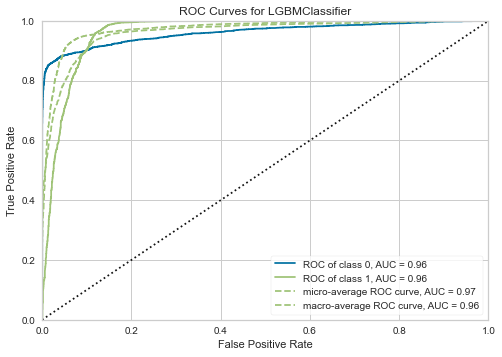

In [37]:
plot_model(best_model, plot='auc')

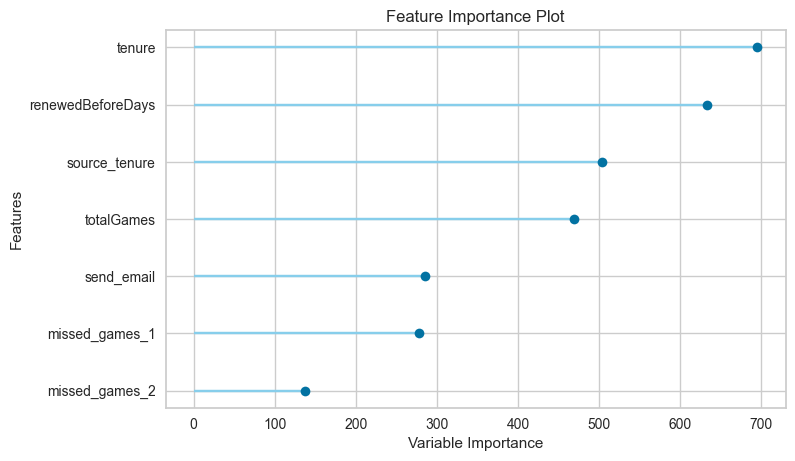

In [35]:
plot_model(best_model, plot='feature')

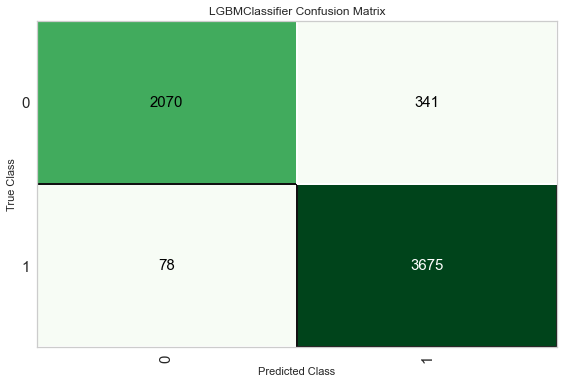

In [36]:
plot_model(best_model, plot='confusion_matrix')

## Results

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?